In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# ✅ DEVICE CONFIGURATION
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ PATH TO YOUR DATA (Make sure image data is under subfolders: Normal, IR Real, OR Real)
data_dir = r"E:\Collaboration Work\With Farooq\Bearings MDPI\Real paderborn"

# ✅ LOAD PRE-TRAINED EFFICIENTNET-B0
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# ✅ MODIFY FINAL CLASSIFIER LAYER (3-class classification)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(model.classifier[1].in_features, 3)
)
model.to(device)

# ✅ TRANSFORMS (From pretrained weights metadata)
transform = weights.transforms()

# ✅ LOAD DATASET
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# ✅ TRAIN-VALID SPLIT (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

# ✅ DATA LOADERS (FAST loading)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# ✅ LOSS FUNCTION & OPTIMIZER
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ✅ TRAINING LOOP
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Training Loss: {avg_loss:.4f}")

# ✅ VALIDATION LOOP
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f"\n✅ Validation Accuracy: {val_acc:.2f}%")


Using device: cuda


Epoch 1/10: 100%|██████████| 224/224 [29:40<00:00,  7.95s/it]


Epoch 1 | Training Loss: 0.3524


Epoch 2/10: 100%|██████████| 224/224 [26:57<00:00,  7.22s/it]


Epoch 2 | Training Loss: 0.1109


Epoch 3/10: 100%|██████████| 224/224 [22:55<00:00,  6.14s/it]


Epoch 3 | Training Loss: 0.0760


Epoch 4/10: 100%|██████████| 224/224 [28:08<00:00,  7.54s/it]


Epoch 4 | Training Loss: 0.0611


Epoch 5/10: 100%|██████████| 224/224 [29:53<00:00,  8.01s/it]


Epoch 5 | Training Loss: 0.0486


Epoch 6/10: 100%|██████████| 224/224 [28:02<00:00,  7.51s/it]


Epoch 6 | Training Loss: 0.0537


Epoch 7/10: 100%|██████████| 224/224 [28:07<00:00,  7.53s/it]


Epoch 7 | Training Loss: 0.0328


Epoch 8/10: 100%|██████████| 224/224 [28:40<00:00,  7.68s/it]


Epoch 8 | Training Loss: 0.0357


Epoch 9/10: 100%|██████████| 224/224 [28:35<00:00,  7.66s/it]


Epoch 9 | Training Loss: 0.0233


Epoch 10/10: 100%|██████████| 224/224 [31:01<00:00,  8.31s/it]


Epoch 10 | Training Loss: 0.0250

✅ Validation Accuracy: 97.98%


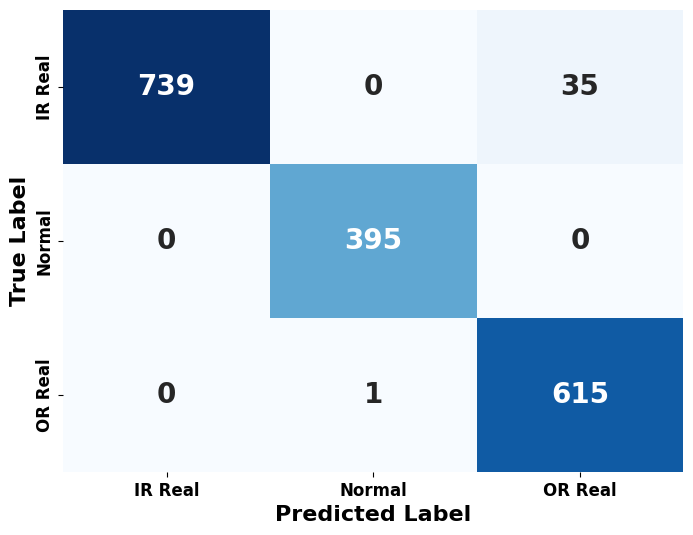


Classification Report:

              precision    recall  f1-score   support

     IR Real       1.00      0.95      0.98       774
      Normal       1.00      1.00      1.00       395
     OR Real       0.95      1.00      0.97       616

    accuracy                           0.98      1785
   macro avg       0.98      0.98      0.98      1785
weighted avg       0.98      0.98      0.98      1785



In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Put model in evaluation mode
model.eval()

# ✅ Get predictions on validation data (or test set if separate)
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # use test_loader if you have separate test data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Class labels (in your case: Normal, IR Real, OR Real)
class_labels = dataset.classes  # Or manually: ['Normal', 'IR Real', 'OR Real']

# ✅ Compute Confusion Matrix & Classification Report
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=class_labels)

# ✅ Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar=False, annot_kws={"size": 20, "fontweight": "bold"})

# ✅ Axis labels and formatting
plt.xlabel('Predicted Label', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
# plt.title('Confusion Matrix (Validation)', fontsize=16, fontweight='bold')

# ✅ Save high-resolution image
plt.savefig("confusion_matrix_val.png", dpi=1000, bbox_inches='tight')
plt.show()

# ✅ Print Classification Report
print("\nClassification Report:\n")
print(report)


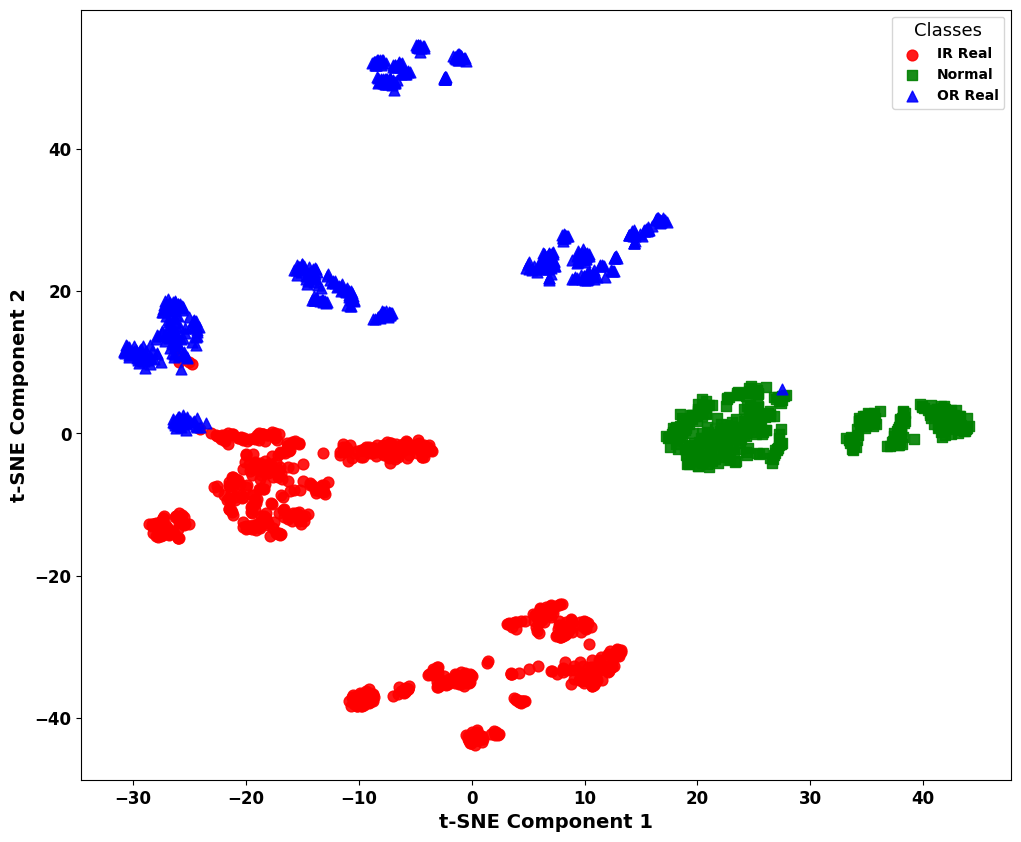

In [5]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# ✅ Make sure model is in evaluation mode
model.eval()

# ✅ Lists to store features and labels
features_list = []
labels_list = []

# ✅ Hook point: get features before final classifier
extractor = model.features  # EfficientNet-B0 feature extractor

with torch.no_grad():
    for images, labels in val_loader:  # Use test_loader if separate
        images = images.to(device)

        features = extractor(images)  # Shape: (B, 1280, 7, 7)
        features = torch.nn.functional.adaptive_avg_pool2d(features, (1, 1))  # Shape: (B, 1280, 1, 1)
        features = features.view(features.size(0), -1)  # Shape: (B, 1280)

        features_list.append(features.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# ✅ Stack features and labels
features_array = np.vstack(features_list)
labels_array = np.concatenate(labels_list)

# ✅ Apply t-SNE
tsne = TSNE(n_components=2, perplexity=60, random_state=42, init='pca', learning_rate='auto')
features_tsne = tsne.fit_transform(features_array)

# ✅ Plot
plt.figure(figsize=(12, 10))

class_labels_real = dataset.classes  # ['IR Real', 'Normal', 'OR Real']
class_colors = ['red', 'green', 'blue']
class_markers = ['o', 's', '^']

for i, class_name in enumerate(class_labels_real):
    mask = (labels_array == i)
    plt.scatter(features_tsne[mask, 0], features_tsne[mask, 1],
                label=class_name,
                color=class_colors[i],
                marker=class_markers[i],
                alpha=0.9,
                s=60)

# ✅ Final touches
# plt.title('t-SNE of Real Bearing Features', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=14, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=14, fontweight='bold')
plt.legend(title="Classes", loc='upper right', prop={'weight': 'bold'}, fontsize=12, title_fontsize='13')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# ✅ Save and Show
plt.savefig("tsne_real_bearing_test.png", dpi=1000, bbox_inches='tight')
plt.show()


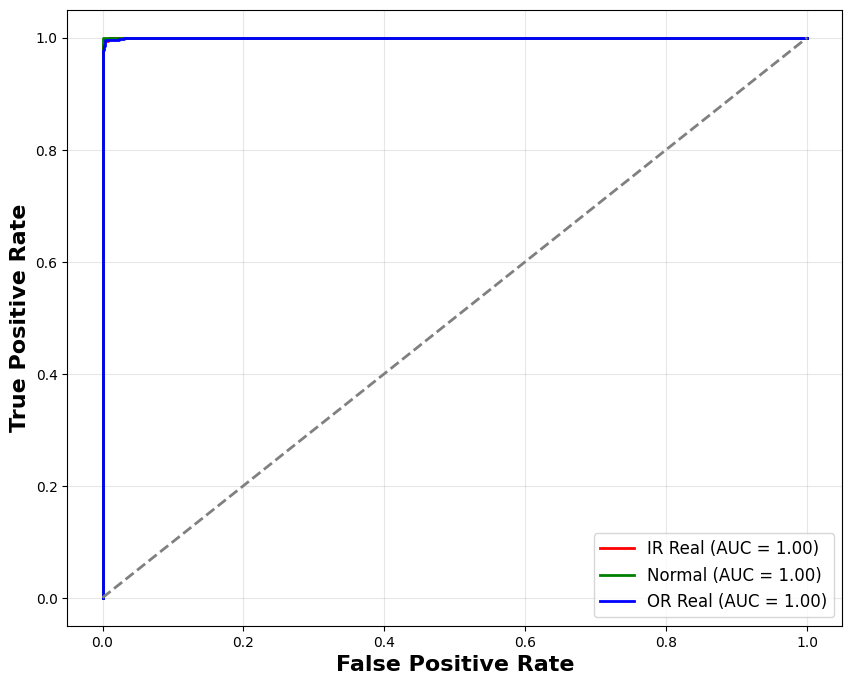

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F

# ✅ Ensure model is in evaluation mode
model.eval()

# ✅ Lists to collect true labels and predicted probabilities
true_labels = []
predicted_probs = []

with torch.no_grad():
    for images, labels in val_loader:  # or test_loader if available
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=1)

        predicted_probs.extend(probs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# ✅ Convert to NumPy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# ✅ Class labels (get from dataset)
class_labels = dataset.classes  # ['IR Real', 'Normal', 'OR Real']
num_classes = len(class_labels)

# ✅ Binarize the true labels for ROC
true_labels_bin = label_binarize(true_labels, classes=range(num_classes))

# ✅ Compute ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ✅ Plot ROC Curves
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue']

for i, class_name in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)

# ✅ Save and show
plt.savefig("roc_curve_real_bearing_test.png", dpi=1000, bbox_inches='tight')
plt.show()


In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Step 1: Compute Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

# ✅ Step 2: Overall Accuracy
accuracy = np.trace(cm) / np.sum(cm)

# ✅ Step 3: Compute TPR, FPR, FNR, FDR
TPR = np.diag(cm) / np.sum(cm, axis=1)  # True Positive Rate (Recall)

FPR = (np.sum(cm, axis=0) - np.diag(cm)) / (np.sum(cm, axis=0) + 1e-9)  # False Positive Rate
FNR = (np.sum(cm, axis=1) - np.diag(cm)) / (np.sum(cm, axis=1) + 1e-9)  # False Negative Rate
FDR = (np.sum(cm, axis=0) - np.diag(cm)) / (np.sum(cm, axis=0) + 1e-9)  # False Discovery Rate

# ✅ Step 4: Precision, F1-Score from Classification Report
report = classification_report(test_labels, test_preds, target_names=class_labels, output_dict=True)

precision = [report[class_name]['precision'] for class_name in class_labels]
f1_scores = [report[class_name]['f1-score'] for class_name in class_labels]

# ✅ Step 5: Print All Paper-Style Metrics
print("\n### 📊 Metrics Summary (for Paper/Table) ###")
print(f"True Positive Rate (TPR) per Class:       {np.round(TPR, 4)}")
print(f"False Positive Rate (FPR) per Class:      {np.round(FPR, 4)}")
print(f"False Negative Rate (FNR) per Class:      {np.round(FNR, 4)}")
print(f"False Discovery Rate (FDR) per Class:     {np.round(FDR, 4)}")
print(f"Precision per Class:                      {np.round(precision, 4)}")
print(f"F1 Score per Class:                       {np.round(f1_scores, 4)}")
print(f"\n✅ Overall Accuracy: {accuracy:.4f}")

# ✅ Step 6: Full Classification Report (Optional for Paper Appendix)
print("\n### 🧾 Full Classification Report ###\n")
print(classification_report(test_labels, test_preds, target_names=class_labels))



### 📊 Metrics Summary (for Paper/Table) ###
True Positive Rate (TPR) per Class:       [0.9548 1.     0.9984]
False Positive Rate (FPR) per Class:      [0.     0.0025 0.0538]
False Negative Rate (FNR) per Class:      [0.0452 0.     0.0016]
False Discovery Rate (FDR) per Class:     [0.     0.0025 0.0538]
Precision per Class:                      [1.     0.9975 0.9462]
F1 Score per Class:                       [0.9769 0.9987 0.9716]

✅ Overall Accuracy: 0.9798

### 🧾 Full Classification Report ###

              precision    recall  f1-score   support

     IR Real       1.00      0.95      0.98       774
      Normal       1.00      1.00      1.00       395
     OR Real       0.95      1.00      0.97       616

    accuracy                           0.98      1785
   macro avg       0.98      0.98      0.98      1785
weighted avg       0.98      0.98      0.98      1785



In [9]:
# ✅ Step 1: Collect predictions and labels
model.eval()

test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # Use test_loader if you have one
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# ✅ Optional: Print basic info
print("Predictions and labels collected.")


Predictions and labels collected.
